# COMP SCI 7327 – Assignment 3

Project Overview:

With the rapidly changing landscape of digital data, humans are struggling to keep up with the information which also makes it extremely difficult for them to distinguish what is true and fake. Given unstructured textual data, identifying whether it provides valid or invalid information is a popular application area in Natural Language Processing (NLP). The need for such systems is further highlighted by the proliferation of fake news related to COVID-19. Due to the timely nature of this application area, in this project, you will develop deep learning models to detect whether a given textual data is a fake news or not. In other words, this will be a binary classification task. Use the following steps, during your project development.

**Guide: how to run this file**

**I. Download the GloVE text file**
1. Open link: https://nlp.stanford.edu/projects/glove/
2. Choose: Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download) glove.6B.zip.
3. After "glove.6B.zip" is downloaded, unzip the file and copy "glove.6B.100d.txt".
4. Paste "glove.6B.100d.txt" to the same folder with this ipynb file.

**II. List required libraries**
1. pandas
2. seaborn
3. re
4. matplotlib
5. sklearn
6. numpy
7. tensorflow
8. nltk
9. keras
10. keras_tuner

In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

from sklearn import preprocessing

import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, Input, Concatenate

import keras_tuner

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tungthai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tungthai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Step 1: Download the dataset and perform Exploratory Data Analysis (EDA) on the training part of the data (8 marks)

EDA is a crucial step in any data science project, which enables us to perform some initial investigations on data so as to discover whether
  - the dataset has any missing values and if they need to be imputed
  - to identify whether the dataset is having any duplicate values and if duplicates need to be removed
  - to spot anomalies and to decide it they need to be removed
  - to check whether it is necessary to normalise or scale any numerical variables
  - to check whether there are categorical variables and encode them
  - to check the distribution of the target variable and check whether we need to incorporate any data balancing techniques

Hints for Step 1:
  - Decide which of the above points are relevant to this project and perform the EDA for the
selected points
  - Use matplotlib and seaborn to draw the required plots.
  - Justify why or why not identified points need to be applied at the preprocessing stage

### 1.1. Read the dataset from files

In [2]:
# Read data from tsv and return a dataframe with columns described in the README
def read_tsv(file):
    
    # Create a "dataframe" or "df" for short
    # Delimiter with tab character
    df = pd.read_csv(file, delimiter='\t')
    
    # labels the columns in the dataset using the data dictionary described in the README
    df.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        # Column 9-13: the total credit history count, including the current statement.
        'barely_true_counts', # barely true counts.
        'false_counts', # false counts.
        'half_true_counts', # half true counts.
        'mostly_true_counts', # mostly true counts.
        'pants_on_fire_counts', # pants on fire counts.
        
        'context' # Column 14: the context (venue / location of the speech or statement).
    ]
    
    return df

# Read train.tsv, valid.tsv, test.tsv
df_train = read_tsv('liar_dataset/train.tsv')
df_valid = read_tsv('liar_dataset/valid.tsv')
df_test = read_tsv('liar_dataset/test.tsv')

In [3]:
display(df_train.head())

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


In [4]:
print("Shape of training dataset:", df_train.shape)
print("Shape of validation dataset:", df_valid.shape)
print("Shape of test dataset:", df_test.shape)
print()

# Show info of dataframe
df_train.info()

Shape of training dataset: (10239, 14)
Shape of validation dataset: (1283, 14)
Shape of test dataset: (1266, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10239 entries, 0 to 10238
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10239 non-null  object 
 1   label                 10239 non-null  object 
 2   statement             10239 non-null  object 
 3   subjects              10237 non-null  object 
 4   speaker               10237 non-null  object 
 5   speaker_job_title     7342 non-null   object 
 6   state_info            8031 non-null   object 
 7   party_affiliation     10237 non-null  object 
 8   barely_true_counts    10237 non-null  float64
 9   false_counts          10237 non-null  float64
 10  half_true_counts      10237 non-null  float64
 11  mostly_true_counts    10237 non-null  float64
 12  pants_on_fire_counts  10237 non-null  float64
 13  context

### 1.2. Exploratory Data Analysis

#### 1.2.1. Dataset analysis

#### 1.2.1.1. Check the dataset has any missing values and if they need to be imputed

In [5]:
print("---Training data set---")
print("Shape:", df_train.shape)
print(df_train.isnull().sum())
print()

print("---Validation data set---")
print("Shape:", df_valid.shape)
print(df_valid.isnull().sum())
print()

print("---Test data set---")
print("Shape:", df_test.shape)
print(df_test.isnull().sum())

---Training data set---
Shape: (10239, 14)
id                         0
label                      0
statement                  0
subjects                   2
speaker                    2
speaker_job_title       2897
state_info              2208
party_affiliation          2
barely_true_counts         2
false_counts               2
half_true_counts           2
mostly_true_counts         2
pants_on_fire_counts       2
context                  102
dtype: int64

---Validation data set---
Shape: (1283, 14)
id                        0
label                     0
statement                 0
subjects                  0
speaker                   0
speaker_job_title       345
state_info              279
party_affiliation         0
barely_true_counts        0
false_counts              0
half_true_counts          0
mostly_true_counts        0
pants_on_fire_counts      0
context                  12
dtype: int64

---Test data set---
Shape: (1266, 14)
id                        0
label                

In [6]:
# Check data that has subjects null
display(df_train.loc[df_train.subjects.isnull()])

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
2141,638.json,false,The fact is that although we have had a presid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9374,1626.json,false,"Joe, I keep hearing you every morning talking ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Imputation strategy**

1. subjects, speaker, party_affiliation, barely_true_counts -> pants_on_fire_counts features

- There are only 2 null records which are very small compared to the total number of records

- Delete these 2 records

2. speaker_job_title, state_info, context are text features

- They are text features

- There is a small amount of null values

- Replace null with 'Missing' string

#### 1.2.1.2. to identify whether the dataset is having any duplicate values and if duplicates need to be removed

In [7]:
# Merge all dataframe into df_all
df_all = pd.concat([df_train, df_valid, df_test])

# Check duplicate row and ID
print("Dataset row duplicated:", df_all.duplicated().sum())
print("Dataset ID duplicated:", df_all['id'].duplicated().sum())

Dataset row duplicated: 0
Dataset ID duplicated: 0


There is no data duplicated in 3 data set, no need to remove any duplicated data.

#### 1.2.1.2. to check numerical variables
- to spot anomalies and to decide it they need to be removed
- to check whether it is necessary to normalise or scale any numerical variables

In [8]:
# Describe all numeric columns
display(df_all.describe().T)

,count,mean,std,min,25%,50%,75%,max
barely_true_counts,12786.0,11.584233,18.979057,0.0,0.0,2.0,12.0,70.0
false_counts,12786.0,13.359768,24.141933,0.0,0.0,2.0,15.0,114.0
half_true_counts,12786.0,17.186454,35.850604,0.0,0.0,3.0,13.0,160.0
mostly_true_counts,12786.0,16.499922,36.168885,0.0,0.0,3.0,12.0,163.0
pants_on_fire_counts,12786.0,6.251447,16.182153,0.0,0.0,1.0,5.0,105.0


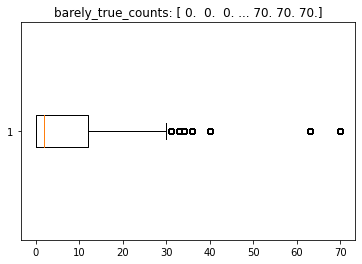

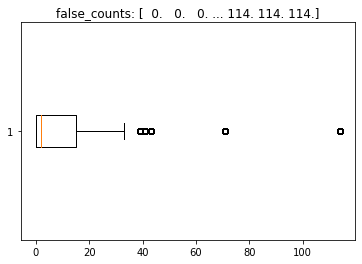

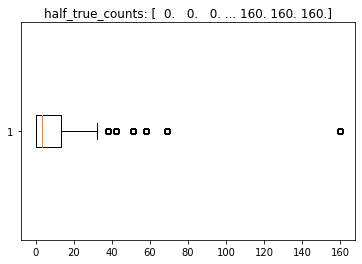

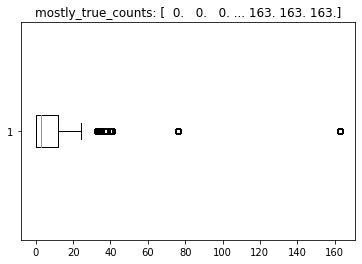

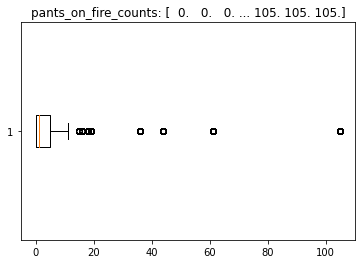

In [9]:
# Visualize using boxplots

# Get dataframe contains only numeric features
df_train_number = df_all[['subjects','barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']]
df_train_number = df_train_number.loc[df_train_number['subjects'].notnull()]
df_train_number = df_train_number[['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']]

# Visualization
for n in range(df_train_number.shape[1]):
    plt.boxplot(df_train_number.iloc[:,n],vert=False)
    plt.title(f'{df_train_number.columns[n]}: {np.sort(df_train_number.iloc[:,n])}')
    plt.show()

barely_true_counts: [ 0.  0.  0. ... 70. 70. 70.]


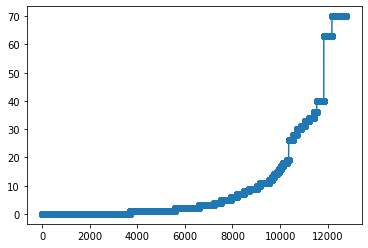

false_counts: [  0.   0.   0. ... 114. 114. 114.]


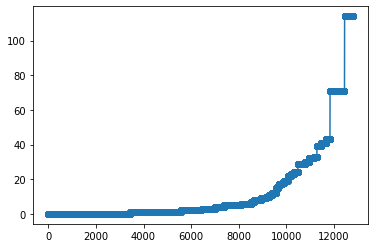

half_true_counts: [  0.   0.   0. ... 160. 160. 160.]


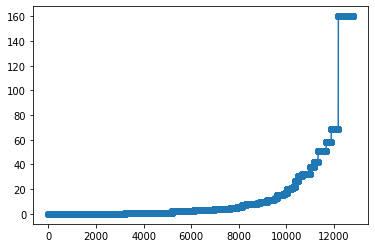

mostly_true_counts: [  0.   0.   0. ... 163. 163. 163.]


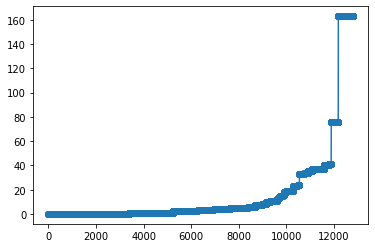

pants_on_fire_counts: [  0.   0.   0. ... 105. 105. 105.]


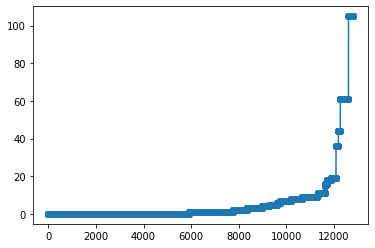

In [10]:
# Visualise using sorted values
for n in range(df_train_number.shape[1]):
    print(f'{df_train_number.columns[n]}: {np.sort(df_train_number.iloc[:,n])}')
    plt.plot(np.sort(df_train_number.iloc[:,n]),'-o')
    plt.show()

Based on these 2 graphs, it can be see that 60 is the threshold for detecting anomalies

In [11]:
# Count number of records for each feature that larger than 60
list_outlier_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts']
threshold = 60

# Find and replace outliers in each column
for index, column in enumerate(list_outlier_columns):
    # Find and count outliers
    series = df_all[column]
    print(column)
    ratio = series.loc[series > threshold].shape[0]*100/series.shape[0]
    print(f"\tRatio of items that are larger than {threshold}: {round(ratio, 2)}%")

barely_true_counts
	Ratio of items that are larger than 60: 7.46%
false_counts
	Ratio of items that are larger than 60: 7.46%
half_true_counts
	Ratio of items that are larger than 60: 7.1%
mostly_true_counts
	Ratio of items that are larger than 60: 7.1%
pants_on_fire_counts
	Ratio of items that are larger than 60: 4.07%


1. All numeric features have not too different range, so it is not necessary to normalise or scale any numerical variables
2. There are some unusually high values, but they account for more than 5% of the total records. => Keep all values

### 1.2.2. Feature analysis

#### 1.2.2.1. to check the distribution of the target variable and check whether we need to incorporate any data balancing techniques

In [12]:
def show_label_chart(input_df, title):
    
    def convert_into_percentage(value):
        return value*100
    
    # Calculate frequencies of labels with normalized
    label_frequencies = input_df['label'].value_counts(normalize=True)
    
    # Convert frequencies into percentage
    label_frequencies = label_frequencies.apply(convert_into_percentage)
    
    # Setting bar chart ordering and colors for readability.
    labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
    colors = [
        'orangered', # pants-fire
        'coral', # false
        'salmon', # barely-true
        'peachpuff', # half-true
        'skyblue', # mostly-true
        'deepskyblue' # true
    ]
    
    # Reindex by labels
    label_frequencies = label_frequencies.reindex(index = labels)
    
    # Plot a horizontal bar chart with a descriptive title
    axis = label_frequencies.plot(kind='barh', figsize=(12, 8), color=colors)
    axis.set_title(f"Label distribution ({title}, sample size={len(input_df)})", size=20);
    
    plt.show()
    
# Setting for chart
sns.set()

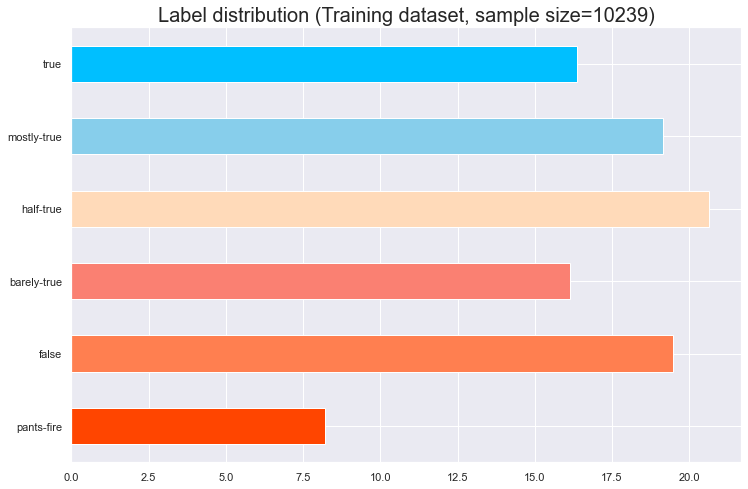

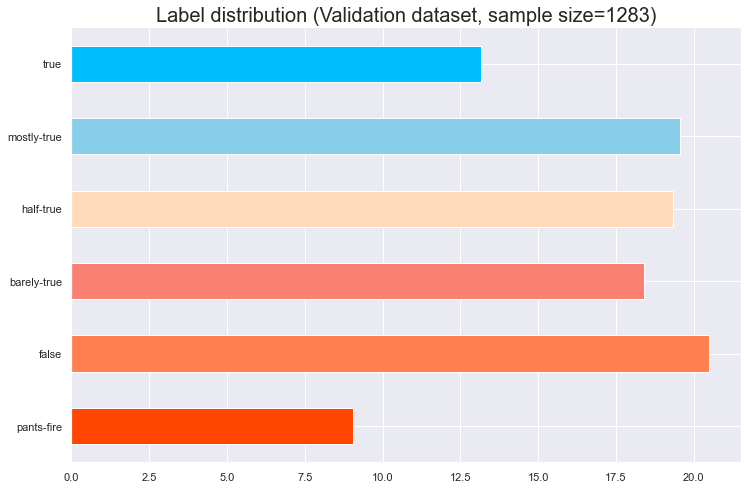

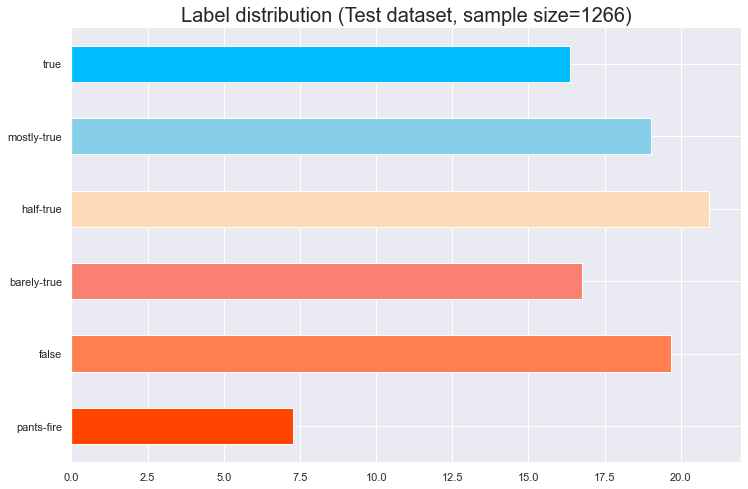

In [13]:
show_label_chart(df_train, "Training dataset")
show_label_chart(df_valid, "Validation dataset")
show_label_chart(df_test, "Test dataset")

Because it is a binary classification task to detect whether a given textual data is a fake news or not, labels should be divided into 2 categories true/false

Classed ‘true’, ‘mostly-true’ and 'half-true' as being accurate statements, and the others as being inaccurate to varying degrees

New labels will be:
1. **True**: true, mostly true and half true
2. **False**: mostly false, false and pants on fire

Because labels are text, they will be encoded in the task 2

In [14]:
# Convert 6 types of label into 2 types (true/false)
def change_label(data_set):
    data_set['label'] = np.where(
        ((data_set['label'] == 'half-true') | # half-true, mostly-true and true label
         (data_set['label'] == 'mostly-true') | 
         (data_set['label'] == 'true')), 
        'true', # change to true label
        np.where( # half-true, barely-true, false, pants-fire label
            (
             (data_set['label'] == 'barely-true') |
             (data_set['label'] == 'false') | 
             (data_set['label'] == 'pants-fire')), 
            'false', # change to false label
            data_set['label']))
    
change_label(df_train)
change_label(df_valid)
change_label(df_test)

In [15]:
print(df_train['label'].value_counts())
print(df_valid['label'].value_counts())
print(df_test['label'].value_counts())

true     5752
false    4487
Name: label, dtype: int64
true     668
false    615
Name: label, dtype: int64
true     713
false    553
Name: label, dtype: int64


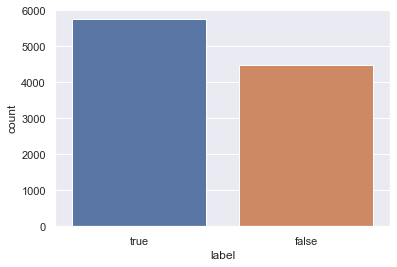

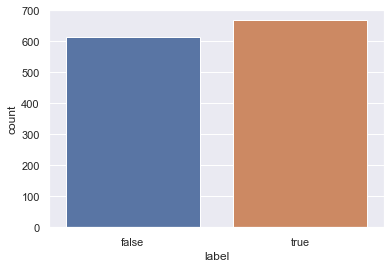

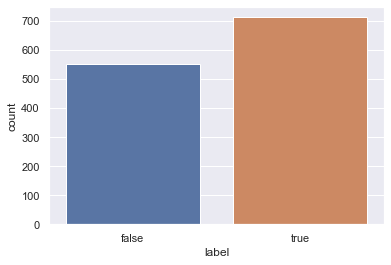

In [16]:
ax = sns.countplot(x=df_train['label'])
plt.show()

ax = sns.countplot(x=df_valid['label'])
plt.show()

ax = sns.countplot(x=df_test['label'])
plt.show()

In [17]:
from sklearn.utils import resample

# Balanced dataset by downsamples
def balance_dataset_2(df):
    # Separate the true and false classes
    df_true  = df[df['label']=='true']
    df_false = df[df['label']=='false']
    
    print("Before downsample")
    print(df['label'].value_counts())
    
    # If dataset balanced, return df
    if (len(df_false) == len(df_true)):
        return df
    
    # False class > True class, downsamples false labels
    # Else downsamples true labels
    if (len(df_false) > len(df_true)):
        # downsamples False labels equal to the number of samples in the True labels
        # df_false = df_false.sample(len(df_true), random_state=42)
        
        df_true_upsample = resample(df_true,
                 replace=True,
                 n_samples=len(df_false),
                 random_state=42)
        
        # concat the true and false dataframes
        df = pd.concat([df_false,df_true_upsample])
        
    else:
        # downsamples False labels equal to the number of samples in the True class
        # df_true = df_true.sample(len(df_false), random_state=42)
        
        df_false_upsample = resample(df_false,
                 replace=True,
                 n_samples=len(df_true),
                 random_state=42)
        
        # concat the true and false dataframes
        df = pd.concat([df_false_upsample,df_true])

    # concat the true and false dataframes
    #df = pd.concat([df_false,df_true])

    # Shuffle the dataset to prevent the model from getting biased by similar samples
    df = df.sample(frac=1, random_state=42)
    
    print("After downsample")
    print(df['label'].value_counts())
    
    return df

After conversion into two labels, the ratio between the labels is imbalanced; hence, it need to corporate a data balancing technique.

#### 1.2.2.2. Explore subjects feature

In [18]:
df_train[['label','statement','subjects']].head()

,label,statement,subjects
0,true,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
1,true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
2,false,Health care reform legislation is likely to ma...,health-care
3,true,The economic turnaround started at the end of ...,"economy,jobs"
4,true,The Chicago Bears have had more starting quart...,education


Because the subjects column has numerous subjects, I will break them into new rows by separating them by a comma.

In [19]:
# Splits dataframe to have entries for each subject in cases where the original entry had multiple subjects.
def subject_split(df):
    # Create a copy dataframe
    df = df.copy()
    
    # Split subjects by spliting comma and convert into a series
    subject_series = df['subjects'].str.split(',').apply(pd.Series, 1).stack()
    
    # Set index, name for series
    subject_series.index = subject_series.index.droplevel(-1)
    subject_series.name = 'subject'
    
    # Drop subjects column
    df.drop('subjects', axis=1, inplace=True)
    
    # Join series as a new subject column in dataframe
    df = df.join(subject_series)
    
    return df

# Create new dataframe with new subject column
df_train_subject = subject_split(df_train)

Create a function to explore a column

In [20]:
def explore_column(df, column, filter_number_statements = 100):
    # Create new dataframe: calculate count label for each subject
    def create_a_breakdown_df(df, column):
        breakdown = df.groupby([column,'label']).agg({'id' : 'count'})
        breakdown.columns = ['count_label']

        return breakdown
    
    # Normalize data
    def normalize_data(df, column):
        # Create a copy dataframe
        df_norm = df.copy()
        df_norm = df.reset_index()
        df_norm = df_norm.set_index([column,'label'])['count_label'].unstack(fill_value=0)

        # Sum of rows
        row_sums = df_norm.sum(axis=1)
        for row_ind in range(len(df_norm.index)):
            # Replace value with normalized value
            df_norm.iloc[row_ind] /= row_sums[row_ind]

        # Set new index
        df_norm = df_norm.stack().reset_index(name='Percentage').set_index([column, 'label'])
        return df_norm
    
    def plot_false_label_only(df, column):
        df = df[df.index.get_level_values(1) == 'false']
        df = df.sort_values('Percentage', ascending=False)
        df = df.reset_index()  
        df.plot(x=column,kind='bar', title="Percentage of Statements as Lies", figsize=(15,5))
    
    # Create a copy dataframe
    df = df.copy()
    
    # Show unique values
    column_unique_values = df[column].unique()
    print(f"There are {len(column_unique_values)} unique values in {column} feature")

    # Group df by column and count
    counts = df.groupby(column).count()

    # Filter column that have over filter_number_statements statements
    column_filter = counts.where(counts['statement'] > filter_number_statements).dropna().index
    df = df[df[column].isin(column_filter)]

    print(f"There are {len(column_filter)} unique values in {column} feature that has over {filter_number_statements} statements")
    
    # Calculate distribution of labels
    column_breakdown = create_a_breakdown_df(df, column)
    print(f"\n{column} breakdown with number of each label (first 5 records):")
    display(column_breakdown.head())
    
    # Normalize column_breakdown and plot bar chart
    column_breakdown_norm = normalize_data(column_breakdown, column)
    print(f"{column} breakdown with ratio of each label (first 5 records):")
    display(column_breakdown_norm.head())
    
    # Visualization of distribution
    column_breakdown_norm.unstack().plot(
        kind='bar', 
        stacked=True, 
        title=f"Label distributation for {column} feature that has over {filter_number_statements} statements",
        figsize=(15,5)
    )
    
    # Plot false label only
    plot_false_label_only(column_breakdown_norm, column)

There are 143 unique values in subject feature
There are 59 unique values in subject feature that has over 100 statements

subject breakdown with number of each label (first 5 records):


count_label
subject              label             
abortion             false          114
                     true           139
campaign-finance     false           86
                     true            98
candidates-biography false          317

subject breakdown with ratio of each label (first 5 records):


Percentage
subject              label            
abortion             false    0.450593
                     true     0.549407
campaign-finance     false    0.467391
                     true     0.532609
candidates-biography false    0.485452

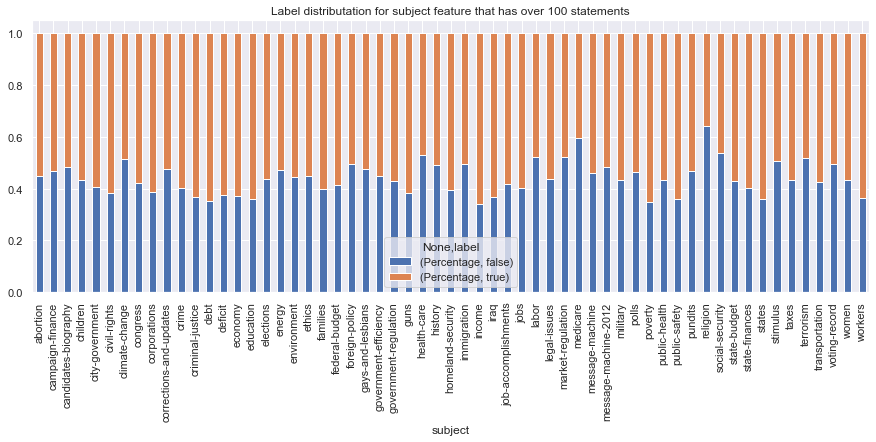

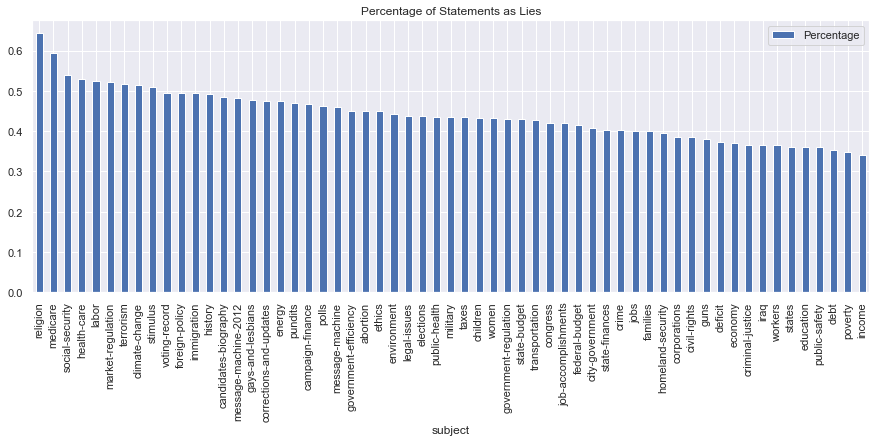

In [21]:
explore_column(df_train_subject, 'subject', 100)

From the normalized plot, we can see that the distribution of the label between the subjects is not too different. Only about 40% of subjects contain 100 or more statements, subject feature selection may lead to bias. The subject feature will not be selected for training

#### 1.2.2.3. Explore speaker feature

There are 2910 unique values in speaker feature
There are 21 unique values in speaker feature that has over 50 statements

speaker breakdown with number of each label (first 5 records):


count_label
speaker      label             
barack-obama false          131
             true           357
bernie-s     false           24
             true            64
blog-posting false           51

speaker breakdown with ratio of each label (first 5 records):


Percentage
speaker      label            
barack-obama false    0.268443
             true     0.731557
bernie-s     false    0.272727
             true     0.727273
blog-posting false    0.864407

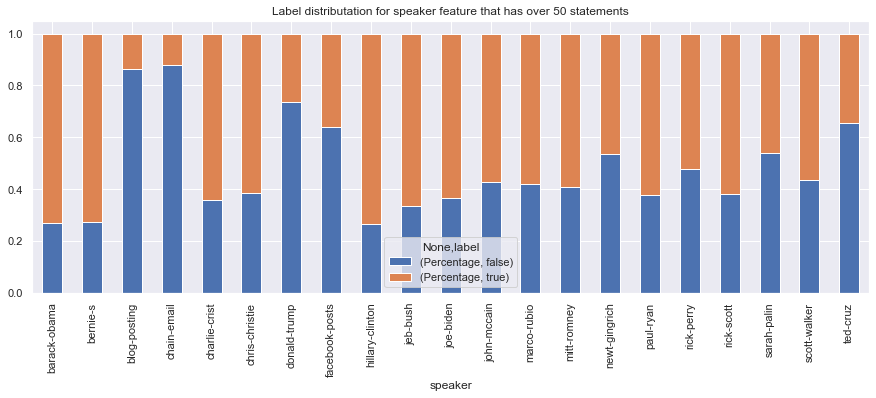

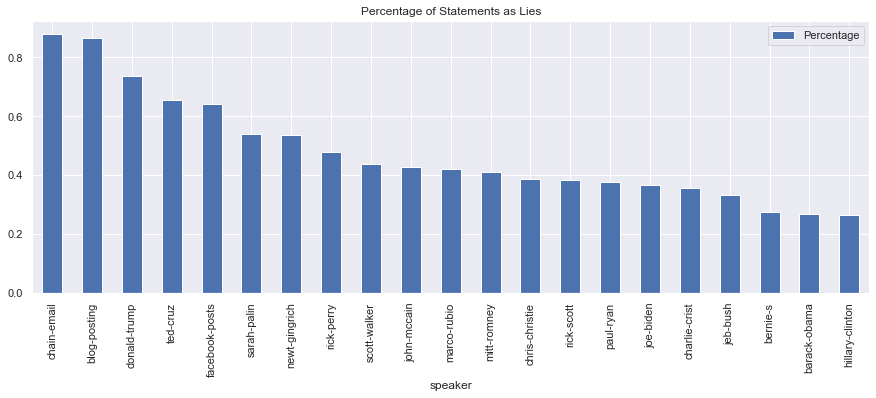

In [22]:
explore_column(df_train, 'speaker', 50)

In breaking down our dataset by the speakers, a startling number of speakers are dishonest. This feature will not be chosen for training, since just 1 percent of speakers have more than 50 statements.

#### 1.2.2.4. Explore speaker job title feature

There are 1185 unique values in speaker_job_title feature
There are 38 unique values in speaker_job_title feature that has over 30 statements

speaker_job_title breakdown with number of each label (first 5 records):


count_label
speaker_job_title label             
Attorney          false           39
                  true            42
Attorney General  false           13
                  true            20
Businessman       false           19

speaker_job_title breakdown with ratio of each label (first 5 records):


Percentage
speaker_job_title label            
Attorney          false    0.481481
                  true     0.518519
Attorney General  false    0.393939
                  true     0.606061
Businessman       false    0.558824

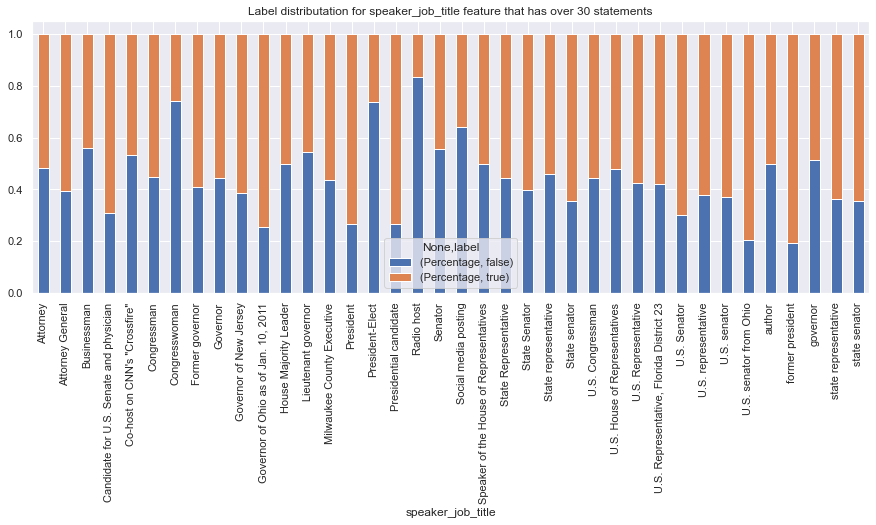

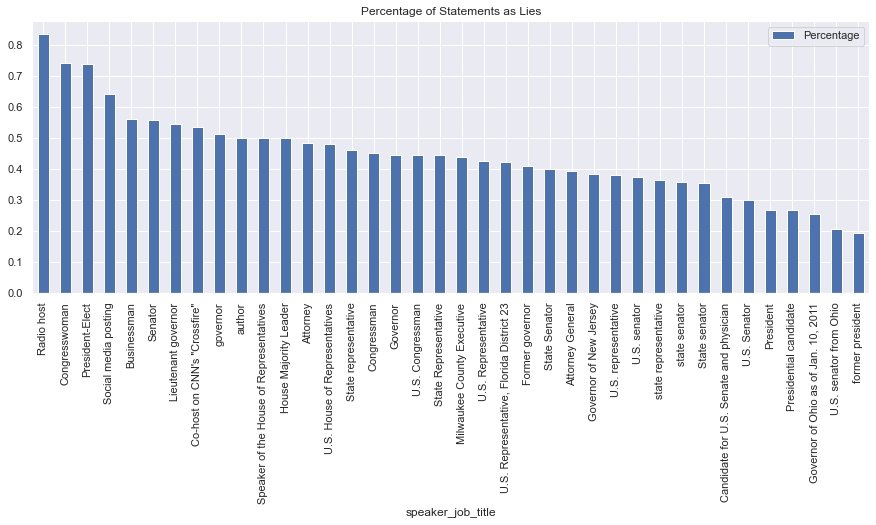

In [23]:
explore_column(df_train, 'speaker_job_title', 30)

Only about 3% of jobs have more than 30 statements, so this feature will not be selected for training.

#### 1.2.2.5. Explore state feature

There are 85 unique values in state_info feature
There are 42 unique values in state_info feature that has over 10 statements

state_info breakdown with number of each label (first 5 records):


count_label
state_info label             
Alabama    false            8
           true             6
Alaska     false           35
           true            30
Arizona    false           75

state_info breakdown with ratio of each label (first 5 records):


Percentage
state_info label            
Alabama    false    0.571429
           true     0.428571
Alaska     false    0.538462
           true     0.461538
Arizona    false    0.412088

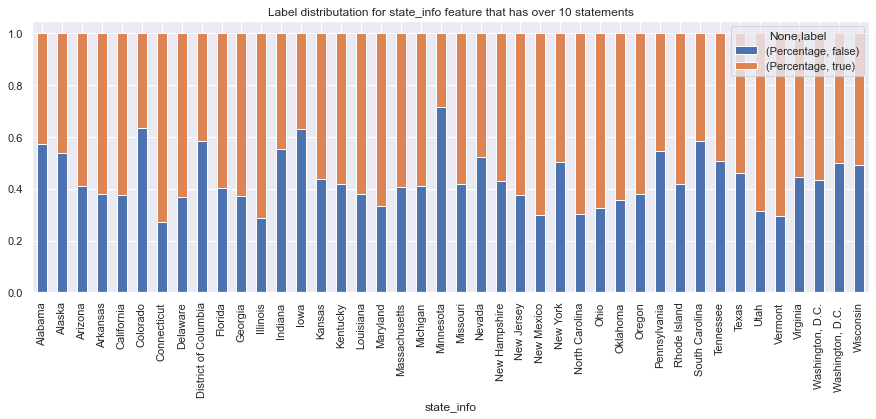

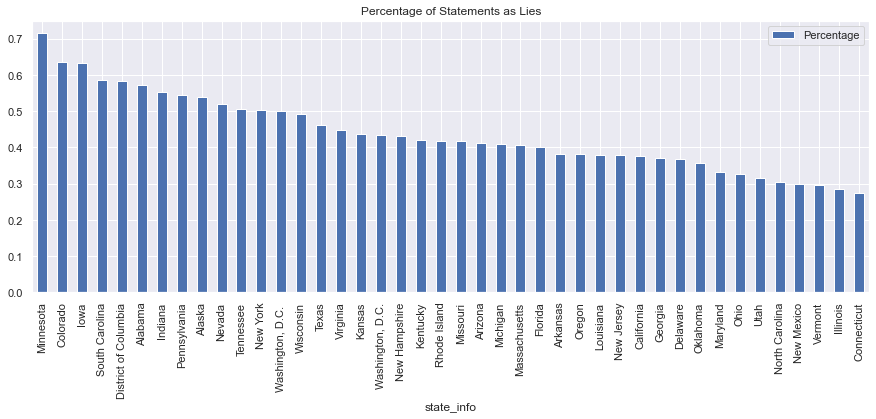

In [24]:
explore_column(df_train, 'state_info', 10)

From the chart above, lies being more prominent in Montana than anywhere else. The distribution of label between other states is not too different. This feature will not be choosen for training

#### 1.2.2.6. Explore the party feature

There are 24 unique values in party_affiliation feature
There are 11 unique values in party_affiliation feature that has over 20 statements

party_affiliation breakdown with number of each label (first 5 records):


count_label
party_affiliation label             
activist          false           14
                  true            25
columnist         false           16
                  true            19
democrat          false         1127

party_affiliation breakdown with ratio of each label (first 5 records):


Percentage
party_affiliation label            
activist          false    0.358974
                  true     0.641026
columnist         false    0.457143
                  true     0.542857
democrat          false    0.337830

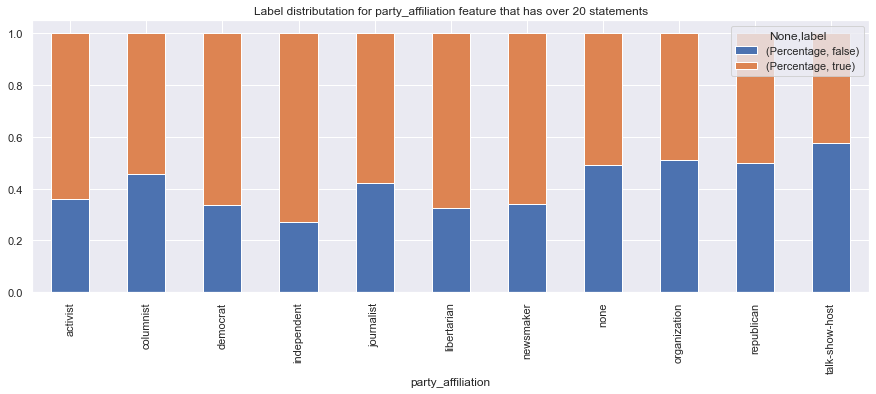

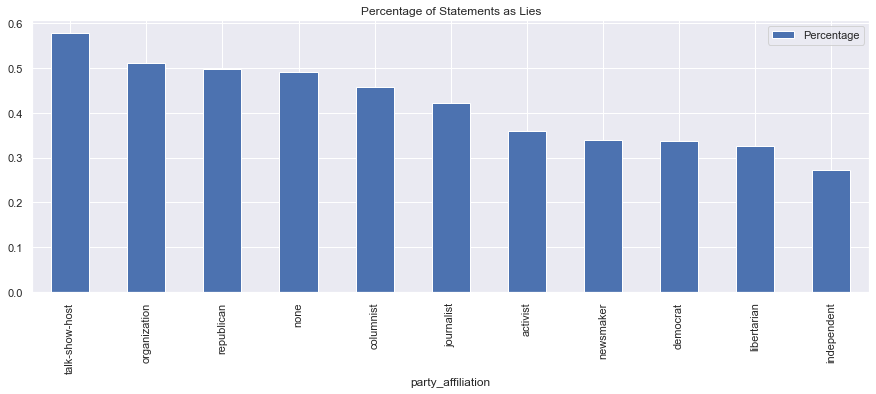

In [25]:
explore_column(df_train, 'party_affiliation', 20)

The distribution of label between party_affiliation is not too different. This feature will not be choosen for training.

#### 1.2.7. Explore context feature

There are 4346 unique values in context feature
There are 49 unique values in context feature that has over 20 statements

context breakdown with number of each label (first 5 records):


count_label
context         label             
a Facebook post false           43
                true            31
a TV ad         false           79
                true           101
a TV ad.        false           20

context breakdown with ratio of each label (first 5 records):


Percentage
context         label            
a Facebook post false    0.581081
                true     0.418919
a TV ad         false    0.438889
                true     0.561111
a TV ad.        false    0.500000

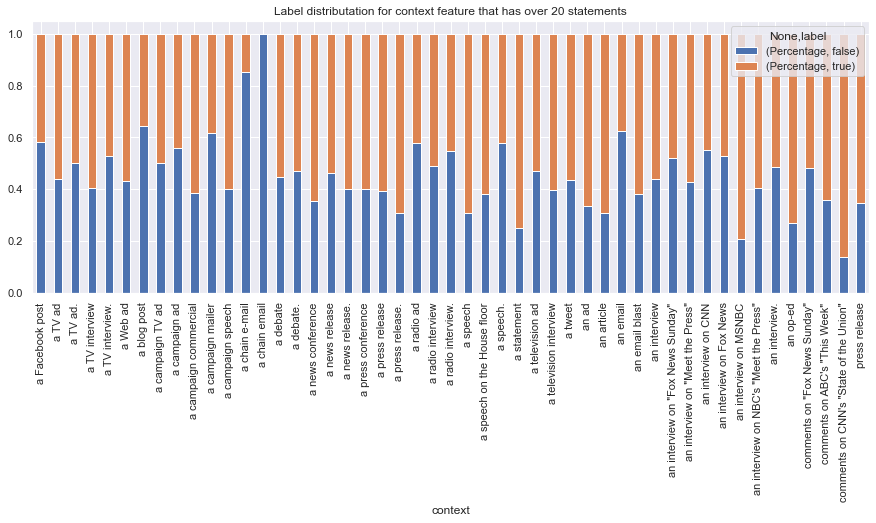

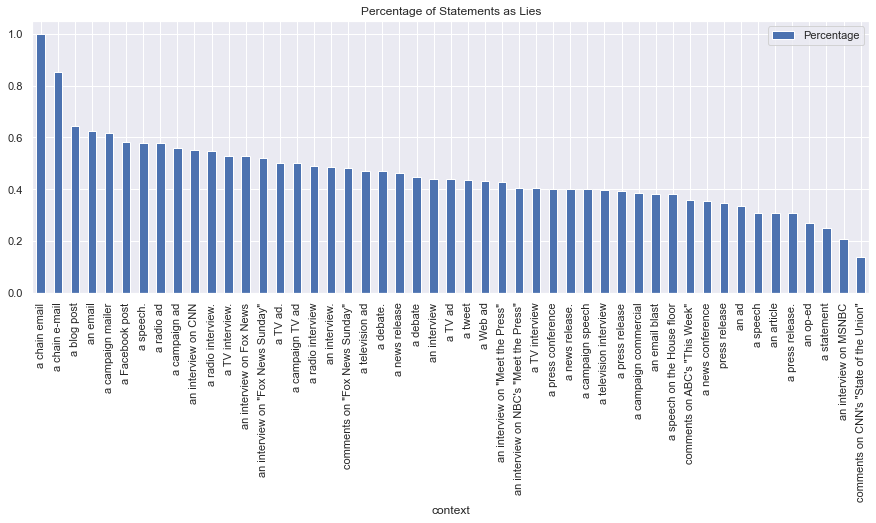

In [26]:
explore_column(df_train, 'context', 20)

It can be seen that a chain email and a chain e-mail have the highest ratio of lies statements. And only about 1% of context feature have more than 30 statements, so this feature will not be selected for training.

After EDA step, statement and history features will be used to train the model that detect whether a given textual data is a fake news or not

## Step 2: Preprocess the dataset (6 marks)
Text preprocessing is a step in the machine learning workflow to clean the text data and make it ready to feed to the models you develop. Why do you need preprocessing? Text data contains noise such as, punctuation, text in a different case, stop words, etc. that may not useful in the modelling stage. Mentioned below are some of the preprocessing techniques that you could use in this project.
- Lowercase
- Remove punctuation
- Remove stop words using NLTK 
- Stemming


Also apply any preprocessing decided at the EDA step.

### 2.1. Imputation with missing values

In [27]:
# Imputing missing value

# 1. Since there are only 2 rows contains, deleting this 2 rows
df_train = df_train[df_train['subjects'].notnull()]

# 2. Columns: speaker_job_title, state_info, context
# Fill missing values with 'Missing'
missing_columns = ['speaker_job_title', 'state_info', 'context']
df_train[missing_columns] = df_train[missing_columns].fillna(value = 'Missing')
df_valid[missing_columns] = df_valid[missing_columns].fillna(value = 'Missing')
df_test[missing_columns] = df_test[missing_columns].fillna(value = 'Missing')

# After imputation
print("After imputation")
print("---Training data set---")
print("Shape:", df_train.shape)
print(df_train.isnull().sum())
print()

print("---Validation data set---")
print("Shape:", df_valid.shape)
print(df_valid.isnull().sum())
print()

print("---Test data set---")
print("Shape:", df_test.shape)
print(df_test.isnull().sum())

After imputation
---Training data set---
Shape: (10237, 14)
id                      0
label                   0
statement               0
subjects                0
speaker                 0
speaker_job_title       0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
dtype: int64

---Validation data set---
Shape: (1283, 14)
id                      0
label                   0
statement               0
subjects                0
speaker                 0
speaker_job_title       0
state_info              0
party_affiliation       0
barely_true_counts      0
false_counts            0
half_true_counts        0
mostly_true_counts      0
pants_on_fire_counts    0
context                 0
dtype: int64

---Test data set---
Shape: (1266, 14)
id                      0
label                   0
statement               0
subjects                

### 2.2. Balanced labels in dataset

In [28]:
# Balanced dataset by downsamples
def balance_dataset(df):
    # Separate the true and false classes
    df_true  = df[df['label']=='true']
    df_false = df[df['label']=='false']
    
    print("Before downsample")
    print(df['label'].value_counts())
    
    # If dataset balanced, return df
    if (len(df_false) == len(df_true)):
        return df
    
    # False class > True class, downsamples false labels
    # Else downsamples true labels
    if (len(df_false) > len(df_true)):
        # downsamples False labels equal to the number of samples in the True labels
        df_false = df_false.sample(len(df_true), random_state=42)
    else:
        # downsamples True labels equal to the number of samples in the True class
        df_true = df_true.sample(len(df_false), random_state=42)

    # concat the true and false dataframes
    df = pd.concat([df_false,df_true])

    # Shuffle the dataset to prevent the model from getting biased by similar samples
    df = df.sample(frac=1, random_state=42)
    
    print("After downsample")
    print(df['label'].value_counts())
    
    return df

In [29]:
print("----Training dataset----")
df_train = balance_dataset(df_train)
print("------------------------")

print()

print("---Validation dataset---")
df_valid = balance_dataset(df_valid)
print("---Validation dataset---")

print()

print("-----Test dataset------")
df_test = balance_dataset(df_test)
print("-----Test dataset------")

----Training dataset----
Before downsample
true     5752
false    4485
Name: label, dtype: int64
After downsample
true     4485
false    4485
Name: label, dtype: int64
------------------------

---Validation dataset---
Before downsample
true     668
false    615
Name: label, dtype: int64
After downsample
false    615
true     615
Name: label, dtype: int64
---Validation dataset---

-----Test dataset------
Before downsample
true     713
false    553
Name: label, dtype: int64
After downsample
false    553
true     553
Name: label, dtype: int64
-----Test dataset------


### 2.3. Endcode label

In [30]:
# Divide X(features) and y(target) for each dataset
X_train = df_train.drop('label', axis = 1)
y_train = df_train['label']

X_valid = df_valid.drop('label', axis = 1)
y_valid = df_valid['label']

X_test = df_test.drop('label', axis = 1)
y_test = df_test['label']

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'label'.
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.fit_transform(y_valid)
y_test = label_encoder.fit_transform(y_test)

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

# Check shape of all targets
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(8970, 2)
(1230, 2)
(1106, 2)


### 2.4. Preprocess data for statement
- Lowercase
- Remove punctuation
- Remove stop words using NLTK
- Stemming

In [31]:
STOPWORDS = set(stopwords.words('english'))

# Stemming
def stemming_text(text):
    # Using porter stemmer algorithm
    ps = PorterStemmer()
 
    # Convert text into list of tokens
    text = word_tokenize(text)
    
    # Stemming each token in text and append into list result
    result = [ps.stem(word) for word in text]
    
    # Join result into a string
    return " ".join(result)

# Preprocess the dataset
def clean_text(sen):

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # lowercase text
    sentence = sentence.lower()
    
    # remove stopwors from text
    sentence = ' '.join(word for word in sentence.split() if word not in STOPWORDS) 

    # stemming
    sentence = stemming_text(sentence)

    return sentence

# Apply clean_text method for a column in a dataset and return a list
def apply_clean_text_for_dataset(dataset, column):
    result = []
    sentences = list(dataset[column])
    for sen in sentences:
        result.append(clean_text(sen))
        
    return result

In [32]:
# preprocessing data for statement feature
X1_train = apply_clean_text_for_dataset(X_train, "statement")
X1_valid = apply_clean_text_for_dataset(X_valid, "statement")
X1_test = apply_clean_text_for_dataset(X_test, "statement")

## Step 3: Construct word embeddings and develop your LSTM deep learning models using Keras sequential API. (5 marks)

For word embeddings use one of the following options.
- Embedding Layer in Keras 
- Word2Vec
- GloVE

You have the freedom to pick your own deep learning architecture. Describe how work embedding is used in your model.

### 3.1. Word embeddings using GloVE

1. Convert statement input into numeric form
- Set the maximum number of words to be used to 5000 words.
- Set the max number of words in each statement to 200 words.
- Set the embedding dimension to 100.
- Using tokenizer from keras.preprocessing.text to get all unique words in the statement feature in the training data set.
- Transform each statement into a sequence of integers.
- Truncate and pad the input sequences so that they are all in the same lenth for modeling.

2. Using GloVE to create embedding matrix
- Read Glove file to get all word vectors.
- For each unique words in the statement of training data set, find its word vector from Glove.
- Create an embedding matrix that will contain all word vectors for all unique words in the statement of training set.

After that load the embedding matrix into a Keras Embedding layer (in the step 3.3), set to be frozen (will not be updated during training)

In [33]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each statement.
MAX_SEQUENCE_LENGTH = 200
# This is fixed.
EMBEDDING_DIM = 100

# Get all unique words in the statement feature in the training data set
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X1_train) # Only fit on training data to use the same tokenizer for all dataset

# Transforms each text in the input to a sequence of integers.
X1_train = tokenizer.texts_to_sequences(X1_train)
X1_valid = tokenizer.texts_to_sequences(X1_valid)
X1_test = tokenizer.texts_to_sequences(X1_test)

# Vocab size of training dataset
vocab_size = len(tokenizer.word_index) + 1

# Truncate and pad the input sequences so that they are all in the same length for modeling
X1_train = pad_sequences(X1_train, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
X1_valid = pad_sequences(X1_valid, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
X1_test = pad_sequences(X1_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

Use GloVE word embeddings for creating word vectors

In [34]:
# Create a embedding dictionary that contains word vectors from glove file
# key: unique word
# value: word vector 
embeddings_dictionary = dict()

# Open glove file: glove.6B.100d.txt with the same folder as this ipynb file
# Download from: https://nlp.stanford.edu/projects/glove/
# Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download)
# 100d means in this file, each word has an equivalent vector of size 100
glove_file = open('glove.6B.100d.txt', encoding="utf8")

# For each word in glove file, get its word vector and put into dictionary
for line in glove_file:
    # Each item in the line separate by a space
    records = line.split()
    
    # The first item in the line is a word
    word = records[0]
    
    # From the 2nd item onwards until the end of the line is the word vector of that word
    # It's an 100 dimension vector because glove.6B.100d is used
    vector_dimensions = asarray(records[1:], dtype='float32')
    
    # Add word vector into dictionary
    embeddings_dictionary[word] = vector_dimensions

# Close file
glove_file.close()

# first create a matrix of zeros, this is the embedding matrix
embedding_matrix = zeros((vocab_size, EMBEDDING_DIM))

# For each unique word in the training data set, find the word vector in the dictionary
# If word vector is found, put the word vector in the embedding matrix
for word, index in tokenizer.word_index.items():
    
    # Get word vector from dictionary by the word
    embedding_vector = embeddings_dictionary.get(word)
    
    # If vector is found, replace vector with current index into embedding matrix
    # words not found in embeddings_dictionary will be all-zeros.
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### 3.2. Prepare numeric data for training

In [35]:
list_meta_columns = [
    'barely_true_counts', 
    'false_counts', 
    'half_true_counts', 
    'mostly_true_counts', 
    'pants_on_fire_counts']
X2_train = X_train[list_meta_columns].values
X2_valid = X_valid[list_meta_columns].values
X2_test = X_test[list_meta_columns].values

### 3.3. Develop a LSTM deep learning model

Create a model with multiple inputs: combine textual information (statement feature) with meta information (history features) and use that as input to the model. The model will be consist of 2 submodel.

The first submodel will accept statement feature as the input. This submodel will consist of 3 layers:
1. an input layer
2. an embedding layer
3. an LSTM layer of 128 units

The second submodel will accept input as the history features (barely_true_counts, false_counts, half_true_counts, mostly_true_counts, pants_on_fire_counts). This submodel also consist of 3 layers:
1. an input layer
2. two dense layers

Outputs from the LSTM layer of the first submodel and the second dense layer of the second submodel will be concatenated and utilised as input to a dense layer with 10 units. Finally, the dense output layer will have 2 units related to 2 labels true and false.

In [36]:
# Choose metrics for the model: binary accuracy, precision, recall and AUC
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]

# Build and return a model
# Hyperparameter: dense_layer_1_unit (default 10), which is used in dense_layer_1 of the second sub-model
def build_model(dense_layer_1_unit = 10):
    
    # 1. The first submodel
    # 1.1. Input layer: shape size has been set to the shape of the input sentence.
    input_first_submodel = Input(shape=(MAX_SEQUENCE_LENGTH,))

    # 1.2. Embedding layer that take input from the input layer
    # input_dim: size of the vocabulary (calculate in the step 3.1)
    # output_dim: 100 that equal to the length of the word vector
    # weights: load the embedding matrix into a Keras Embedding layer
    # set trainable=False to prevent the weights from being updated during training.
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_first_submodel)

    # 1.3. LSMT layer that is after embedding layer
    LSTM_Layer = LSTM(100, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)

    # 2. The second submodel
    # 2.1. Input layer: the shape corresponds to 5 features related to history features
    input_second_submodel = Input(shape=(5,))

    # 2.2. Dense layer 1: accept input from input layer of submodel
    dense_layer_1 = Dense(dense_layer_1_unit, activation='relu')(input_second_submodel)

    # 2.3. Dense layer 2: accept input from dense layer 1
    dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

    # 3. Model: concatenate the output from the first submodel with the output from the second submodel
    # The output of the first submodel is the output from the LSTM_Layer
    # The output of the second submodel is the output from the dense_layer_2

    # 3.1. Concatenate layer from LSTM layer and dense layer 2
    concat_layer = Concatenate()([LSTM_Layer, dense_layer_2])

    # 3.2. Dense layer is after the concat layer
    dense_layer_3 = Dense(10, activation='relu')(concat_layer)

    # 3.3. Output layer of the model
    # Output dimension: 2 because it's true/false label
    # Activation: softmax for classification
    output = Dense(2, activation='softmax')(dense_layer_3)

    # Create the model
    model = Model(inputs=[input_first_submodel, input_second_submodel], outputs=output)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)
    
    return model

## Step 4: Parameter Tuning (6 marks)
In machine learning, hyperparameter tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. In this step, select one or two parameters and optimise them to further improve the performance of your LSTM model. Use appropriate methodology for parameter tuning.

Choose 2 hyperparameters:
1. unit of the first dense layer in the second submodel (min value 10, max value 130, step 30)
2. number of epochs

Using keras tuner in hyperparamter tuning step

**1. Tuning the unit of the first dense layer in the second submodel**

In [37]:
# Setting list values of hyperparameters
def build_model_with_hyperparameter(hp):
    dense_layer_1_unit = hp.Int('dense_layer_1_unit', min_value=10, max_value=130, step=30)
    
    # call existing model-building code with the hyperparameter values.
    model = build_model(dense_layer_1_unit=dense_layer_1_unit)
    
    return model

In [38]:
# Declare tuner
tuner = keras_tuner.Hyperband(
    build_model_with_hyperparameter,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    overwrite=True
)

# Summary hyperparmeters
tuner.search_space_summary()

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

Search space summary
Default search space size: 1
dense_layer_1_unit (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 130, 'step': 30, 'sampling': None}


In [39]:
with tf.device('/cpu:0'):
    tuner.search(
        [X1_train, X2_train], 
        y_train, 
        epochs=10, 
        validation_data=([X1_valid, X2_valid], y_valid), 
        callbacks=[stop_early]
    )
    
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"The hyperparameter search is complete.\ndense_layer_1_unit = {best_hps.get('dense_layer_1_unit')}")

Trial 5 Complete [00h 01m 48s]
val_accuracy: 0.7178861498832703

Best val_accuracy So Far: 0.7178861498832703
Total elapsed time: 00h 08m 58s
INFO:tensorflow:Oracle triggered exit
The hyperparameter search is complete.
dense_layer_1_unit = 100


**2. Tuning the number of epochs**

In [40]:
# Build the model with the optimal hyperparameters and train it on the data for 15 epochs to find the best epochs
model = tuner.hypermodel.build(best_hps)

# Training model
with tf.device('/cpu:0'):
    history = model.fit(
            x=[X1_train, X2_train], 
            y=y_train, 
            batch_size=128, 
            epochs=15, 
            verbose=1, 
            validation_data=([X1_valid, X2_valid], y_valid)
        )    

# Find the best epoch
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

# The best epoch
print(f'The best epoch: {best_epoch}')

Epoch 1/15
71/71 [==============================] - 40s 546ms/step - loss: 0.6733 - accuracy: 0.6648 - precision: 0.6649 - recall: 0.6644 - auc: 0.6864 - val_loss: 0.6581 - val_accuracy: 0.6252 - val_precision: 0.6252 - val_recall: 0.6252 - val_auc: 0.6919
Epoch 2/15
71/71 [==============================] - 41s 571ms/step - loss: 0.6250 - accuracy: 0.6993 - precision: 0.6993 - recall: 0.6993 - auc: 0.7417 - val_loss: 0.5810 - val_accuracy: 0.7195 - val_precision: 0.7195 - val_recall: 0.7195 - val_auc: 0.7881
Epoch 3/15
71/71 [==============================] - 40s 567ms/step - loss: 0.5668 - accuracy: 0.7178 - precision: 0.7178 - recall: 0.7178 - auc: 0.7872 - val_loss: 0.5435 - val_accuracy: 0.7089 - val_precision: 0.7089 - val_recall: 0.7089 - val_auc: 0.8031
Epoch 4/15
71/71 [==============================] - 41s 573ms/step - loss: 0.5372 - accuracy: 0.7187 - precision: 0.7187 - recall: 0.7187 - auc: 0.8050 - val_loss: 0.5309 - val_accuracy: 0.7154 - val_precision: 0.7154 - val_recal

## Step 5: Model Evaluation (5 marks)
Use standard evaluation metrics such as precision, recall, F-measure and AUC to evaluate the performance of your models before and after the parameter tuning.

**Before the hyperparameter tuning**

In [41]:
# Get the model with default hyperparameter
model = build_model()
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 100)     732000      ['input_5[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 10)           60          ['input_6[0][0]']                
                                                                                            

Epoch 1/10
71/71 [==============================] - 43s 586ms/step - loss: 0.7280 - accuracy: 0.5699 - precision: 0.5699 - recall: 0.5696 - auc: 0.6065 - val_loss: 0.6662 - val_accuracy: 0.6065 - val_precision: 0.6065 - val_recall: 0.6065 - val_auc: 0.6461
Epoch 2/10
71/71 [==============================] - 39s 556ms/step - loss: 0.6599 - accuracy: 0.6200 - precision: 0.6200 - recall: 0.6200 - auc: 0.6620 - val_loss: 0.6388 - val_accuracy: 0.6829 - val_precision: 0.6829 - val_recall: 0.6829 - val_auc: 0.7075
Epoch 3/10
71/71 [==============================] - 39s 554ms/step - loss: 0.6391 - accuracy: 0.6602 - precision: 0.6602 - recall: 0.6602 - auc: 0.7033 - val_loss: 0.6198 - val_accuracy: 0.6943 - val_precision: 0.6943 - val_recall: 0.6943 - val_auc: 0.7413
Epoch 4/10
71/71 [==============================] - 40s 559ms/step - loss: 0.6116 - accuracy: 0.6936 - precision: 0.6936 - recall: 0.6936 - auc: 0.7398 - val_loss: 0.5854 - val_accuracy: 0.6935 - val_precision: 0.6935 - val_recal

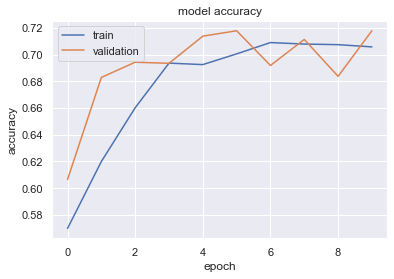

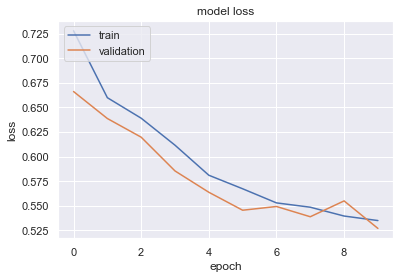

35/35 [==============================] - 49s 1s/step - loss: 0.5418 - accuracy: 0.7052 - precision: 0.7052 - recall: 0.7052 - auc: 0.7948
Test Score: 0.541752815246582
Test Accuracy: 0.7052441239356995
Test Precision: 0.7052441239356995
Test Recall: 0.7052441239356995
Test AUC: 0.794803261756897


In [42]:
# Training model
with tf.device('/cpu:0'):
    history = model.fit(
            x=[X1_train, X2_train], 
            y=y_train, 
            batch_size=128, 
            epochs=10, 
            verbose=1, 
            validation_data=([X1_valid, X2_valid], y_valid)
        )    
    
# Plot the training epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

# Evaluation
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("Test Precision:", score[2])
print("Test Recall:", score[3])
print("Test AUC:", score[4])

**After the hyperparameter tuning**

Epoch 1/14
71/71 [==============================] - 43s 590ms/step - loss: 0.6662 - accuracy: 0.6553 - precision: 0.6554 - recall: 0.6549 - auc: 0.6891 - val_loss: 0.6392 - val_accuracy: 0.6642 - val_precision: 0.6642 - val_recall: 0.6642 - val_auc: 0.7314
Epoch 2/14
71/71 [==============================] - 40s 569ms/step - loss: 0.6256 - accuracy: 0.6911 - precision: 0.6911 - recall: 0.6911 - auc: 0.7354 - val_loss: 0.5835 - val_accuracy: 0.7309 - val_precision: 0.7309 - val_recall: 0.7309 - val_auc: 0.7820
Epoch 3/14
71/71 [==============================] - 42s 589ms/step - loss: 0.5716 - accuracy: 0.7230 - precision: 0.7230 - recall: 0.7230 - auc: 0.7840 - val_loss: 0.5450 - val_accuracy: 0.7244 - val_precision: 0.7244 - val_recall: 0.7244 - val_auc: 0.8065
Epoch 4/14
71/71 [==============================] - 41s 579ms/step - loss: 0.5461 - accuracy: 0.7188 - precision: 0.7188 - recall: 0.7188 - auc: 0.8001 - val_loss: 0.5278 - val_accuracy: 0.7195 - val_precision: 0.7195 - val_recal

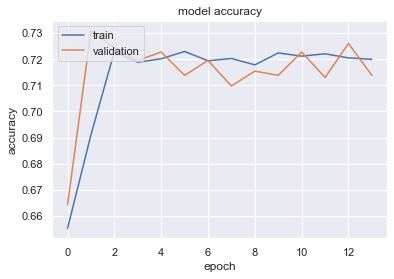

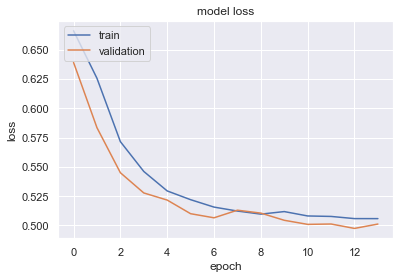

35/35 [==============================] - 50s 1s/step - loss: 0.5203 - accuracy: 0.7215 - precision: 0.7215 - recall: 0.7215 - auc: 0.8097
Test Score: 0.5203258991241455
Test Accuracy: 0.7215189933776855
Test Precision: 0.7215189933776855
Test Recall: 0.7215189933776855
Test AUC: 0.8097419738769531


In [43]:
hypermodel = tuner.hypermodel.build(best_hps)

# Training model with the best epoch
with tf.device('/cpu:0'):
    history = hypermodel.fit(
            x=[X1_train, X2_train], 
            y=y_train, 
            batch_size=128, 
            epochs=best_epoch, 
            verbose=1, 
            validation_data=([X1_valid, X2_valid], y_valid)
        )    
    
# Plot the training epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

# Evaluation
score = hypermodel.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("Test Precision:", score[2])
print("Test Recall:", score[3])
print("Test AUC:", score[4])